# (A) Dependencies

In [116]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
#from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# (B) Dataset

### Downloading the dataset via kaggle api
- [Dataset Source](https://www.kaggle.com/datasets/jangedoo/utkface-new)

In [117]:
# Download kaggle api
!pip install -q kaggle

In [118]:
# Creat the convenient dir for token. (The system will seach this dir)
! mkdir ~/.kaggle

- Upload your kaggle token
- For creating a token
  - Sign in your Kaggle account,
  - Open Account section from  your icon menu
  - Scroll to API section
  -  Click on __Create New API Token__
     - It will download kaggle.json file on your machine. 
  - Upload this kaggle.json file into your working directory on your google colab session.
  - Run floowing codes

In [119]:
# upload your kaggle token to download dataset.
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [120]:
# Copy the json file into correct path, then remove the firt one it
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [121]:
# Set the token can't readable for other user if you save it somewhere
! chmod 600 ~/.kaggle/kaggle.json

In [122]:
# Download your data "Competition-name"
#! kaggle competitions download -c 'competition-name'
!kaggle datasets download -d jangedoo/utkface-new

 94% 311M/331M [00:03<00:00, 60.8MB/s]
100% 331M/331M [00:03<00:00, 99.8MB/s]


In [123]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [124]:
!ls

crop_part1  GenAgeModel      sample_data  samples.zip  utkface_aligned_cropped
drive	    GenAgeModel.zip  Samples	  UTKFace      utkface-new.zip


## Loading the dataset

In [10]:
data_path = "UTKFace"
batch_size = 64

In [11]:
# Defşnşng the data collectors
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(data_path)):
    
    # getting the file path
    image_path = os.path.join(data_path, filename)
    temp = filename.split('_')
    
    # extracting the data from naming notation
    age = int(temp[0])
    gender = int(temp[1])
    
    # collecting the data
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,UTKFace/46_1_4_20170104172709843.jpg.chip.jpg,46,1
1,UTKFace/27_0_0_20170116204347283.jpg.chip.jpg,27,0
2,UTKFace/23_1_3_20170104222844871.jpg.chip.jpg,23,1
3,UTKFace/26_0_1_20170117200138532.jpg.chip.jpg,26,0
4,UTKFace/38_1_0_20170104192820567.jpg.chip.jpg,38,1


In [13]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Displaying the images

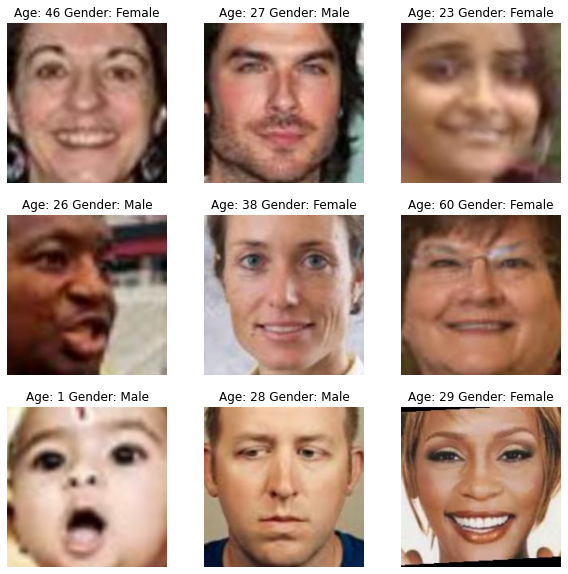

In [14]:
# to display grid of images
plt.figure(figsize=(10, 10))
files = df.iloc[0:9]

for index, file_path, age, gender in files.itertuples():
    
    # laoding the image as convenient form
    img = load_img(file_path)
    img = np.array(img)
    
    # plotting the image
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    
    # configurating the figure
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Exploratory Data Analysis

<Axes: ylabel='count'>

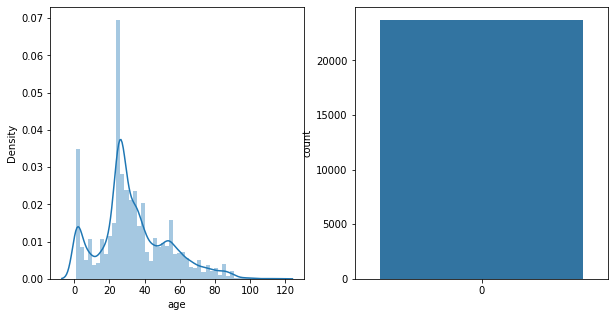

In [15]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(df['age'])

plt.subplot(1,2,2)
sns.countplot(df['gender'])

# (C) Preprocessing

## Feature Extraction

In [16]:
input_shape = (128, 128, 1)

### Preparing the images

In [17]:
def extract_features(images):
    # Collecting the images
    features = []
    for image in tqdm(images):
        # grayscaling
        img = load_img(image, grayscale=True)
        
        # resizing
        img = img.resize((128, 128), Image.ANTIALIAS)
        
        # converting the convenient form
        img = np.array(img)
        features.append(img)
      
    # typecasting
    features = np.array(features)
    
    # grayscaling
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [18]:
df.columns

Index(['image', 'age', 'gender'], dtype='object')

In [19]:
# extracting the images
X = extract_features(df['image'])

# normalize the images
X = X/255.0

  0%|          | 0/23708 [00:00<?, ?it/s]

In [20]:
X.shape

(23708, 128, 128, 1)

### Preparing the target variables

In [21]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

# (D) Modelling

## Architecture

In [22]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

## Training

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))

# Temporary save paths
checkpoint_path = "GenModel"
tb_log_dir = "./logs"

In [24]:
callbacks = [
    #LearningRateScheduler(step_decay),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    CSVLogger(filename='training.log'),
    #LambdaCallback(on_epoch_end=print_current_lr)
]

In [25]:
# train model
t_p = {
    "x":X, 
    "y":[y_gender, y_age], 
    "batch_size":32, 
    "epochs":30, 
    "callbacks":callbacks, 
    "validation_split":0.2
}

history = model.fit(**t_p)

Epoch 1/30
593/593 [==============================] - ETA: 0s - loss: 15.1833 - gender_out_loss: 0.6520 - age_out_loss: 14.5313 - gender_out_accuracy: 0.6043 - age_out_accuracy: 0.0463
Epoch 1: val_loss improved from inf to 12.14542, saving model to GenModel
593/593 [==============================] - 30s 26ms/step - loss: 15.1833 - gender_out_loss: 0.6520 - age_out_loss: 14.5313 - gender_out_accuracy: 0.6043 - age_out_accuracy: 0.0463 - val_loss: 12.1454 - val_gender_out_loss: 0.5142 - val_age_out_loss: 11.6312 - val_gender_out_accuracy: 0.7537 - val_age_out_accuracy: 0.0403
Epoch 2/30
592/593 [============================>.] - ETA: 0s - loss: 11.2855 - gender_out_loss: 0.4650 - age_out_loss: 10.8205 - gender_out_accuracy: 0.7781 - age_out_accuracy: 0.0291
Epoch 2: val_loss improved from 12.14542 to 10.29980, saving model to GenModel
593/593 [==============================] - 14s 23ms/step - loss: 11.2854 - gender_out_loss: 0.4648 - age_out_loss: 10.8205 - gender_out_accuracy: 0.7780 -

## Training History

In [26]:
history.history.keys()

dict_keys(['loss', 'gender_out_loss', 'age_out_loss', 'gender_out_accuracy', 'age_out_accuracy', 'val_loss', 'val_gender_out_loss', 'val_age_out_loss', 'val_gender_out_accuracy', 'val_age_out_accuracy'])

In [35]:
# Unpackaging the data
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']
epochs = range(len(acc))

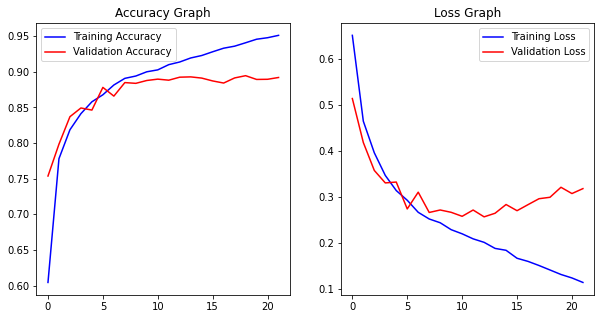

In [37]:
plt.figure(figsize=(10,5))

# plot results for gender
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Prediction

In [39]:
def predict_randomly(image_index):
  # predicting and adjuting output
  pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])

  # plotting the figure
  plt.axis('off')
  plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

  # plotting the actual and prediction
  print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
  print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

1/1 [==============================] - 0s 23ms/step
Original Gender: Female Original Age: 48
Predicted Gender: Female Predicted Age: 52


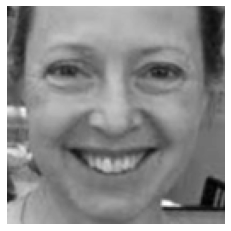

In [40]:
predict_randomly(100)

1/1 [==============================] - 0s 45ms/step
Original Gender: Female Original Age: 36
Predicted Gender: Female Predicted Age: 36


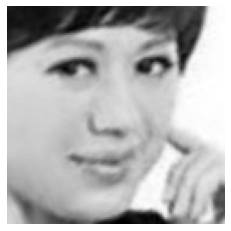

In [43]:
predict_randomly(2500)

1/1 [==============================] - 0s 31ms/step
Original Gender: Female Original Age: 50
Predicted Gender: Female Predicted Age: 43


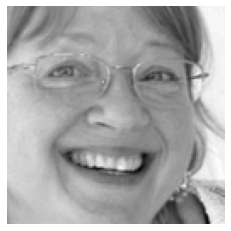

In [42]:
predict_randomly(10000)

1/1 [==============================] - 0s 33ms/step
Original Gender: Male Original Age: 45
Predicted Gender: Male Predicted Age: 44


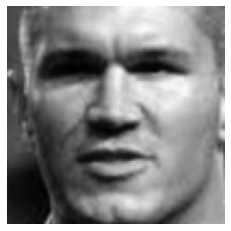

In [44]:
predict_randomly(999)

# (E) Saving the model

## Save the best model

In [ ]:
# Load the best weights
#model.load_weights(checkpoint_path)

In [27]:
best_model_save_path = f"GenAgeModel" 
model.save(best_model_save_path)

## Getting the spare into drive

In [31]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [32]:
!cp -r /content/GenAgeModel /content/drive/MyDrive/Home/Projects/GenderAgePrediction

## Compressing the model

In [28]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path

In [29]:
import os 
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

## Download the model

In [30]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (F) Demo App

## APP (loading from file)

### Dependencies

In [1]:
import os
if os.system("pip freeze | grep gradio==") != 0: os.system("pip install gradio")

In [2]:
from PIL import Image, ImageOps
import tensorflow as tf
import gradio as gr
import numpy as np
import nltk
import PIL

### Load the files

#### From dir

In [3]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [4]:
!cp -r /content/drive/MyDrive/Home/Projects/GenderAgePrediction/GenAgeModel /content 

#### Extracting the files

In [4]:
#!unzip GenAgeModel.zip

Archive:  GenAgeModel.zip
   creating: GenAgeModel/
   creating: GenAgeModel/variables/
  inflating: GenAgeModel/variables/variables.index  
  inflating: GenAgeModel/variables/variables.data-00000-of-00001  
  inflating: GenAgeModel/saved_model.pb  
   creating: GenAgeModel/assets/
 extracting: GenAgeModel/fingerprint.pb  
  inflating: GenAgeModel/keras_metadata.pb  


In [5]:
!unzip samples.zip #GenAgeModel.zip

Archive:  samples.zip
  inflating: Samples/1.png           
  inflating: Samples/2.png           
  inflating: Samples/3.png           
  inflating: Samples/4.png           


### Declerate the utils

In [6]:
# declerations
model_path = 'GenAgeModel' 
gender_dict = {0:'Male', 1:'Female'}

# laoding the model
model = tf.keras.models.load_model(model_path)

In [9]:
# Define a function to make predictions with the model

def pre_process(image):
  
  # Grayscaling
  image = ImageOps.grayscale(image)
  
  # resizing for the model
  image = image.resize((128, 128), Image.ANTIALIAS)
  
  # type casting to further processes
  image = np.array(image)

  # value scaling into 0-1 value range
  image = image/255.0

  return image


def predict(image):

  image = pre_process(image)

  # prediction
  pred = model.predict(image.reshape(1, 128, 128, 1))
  
  # extracting the results
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  
  return pred_gender, pred_age

In [10]:
im = Image.open("/content/Samples/2.png")

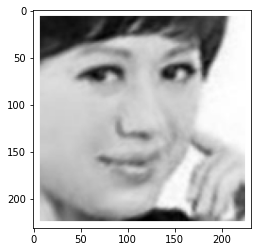

In [11]:
import matplotlib.pyplot as plt
plt.imshow(np.array(im))

In [12]:
predict(im)

1/1 [==============================] - 0s 422ms/step


('Female', 27)

##### Start Remove

In [109]:
img = np.array(im)

In [110]:
img.shape, img.min(), img.max()

((231, 231, 4), 0, 255)

In [ ]:
/content/Samples/4.png

In [140]:

im2 = Image.open("/content/Samples/download (3).png")
img = np.array(im2)
img.shape, img.min(), img.max()

((224, 224, 3), 0, 204)

In [126]:
predict(im2)

1/1 [==============================] - 0s 81ms/step


('Male', 106)

In [141]:
im2 = Image.open("/content/Samples/download (3).png")
img = np.array(im2)
img.shape, img.min(), img.max()

((224, 224, 3), 0, 204)

In [115]:
im2 = Image.open("/content/Samples/download (3).png")
img = np.array(im2)
img.shape, img.min(), img.max()

((224, 224, 3), 0, 204)

In [142]:
im2 = Image.open("/content/Samples/download (3).png")
img = np.array(im2)
img.shape, img.min(), img.max(), predict(im2)

1/1 [==============================] - 0s 37ms/step


((224, 224, 3), 0, 204, ('Female', 16))

In [160]:
!rm -r Samples

In [161]:
!unzip samples.zip

Archive:  samples.zip
  inflating: Samples/1.png           
  inflating: Samples/2.png           
  inflating: Samples/3.png           
  inflating: Samples/4.png           


##### Stop Remove

### Create and launch the demo app

In [16]:
import gradio as gr

u_gif = "/content/usage.gif"

def transmit(image):return image
def usage_gif():
  return u_gif


with gr.Blocks() as demo:
    # defining the components
    gr.Markdown("Use the __capture icon__ where on the __bottom center of the camera window__ for __taking photo__")
    gr.Markdown("For better prediction, pose like examples. Get close the camera, open the lights etc...")
    with gr.Row():
      image = gr.Image(value=u_gif, shape=(224, 224), type="pil",abel="upload images")
      cam_image = gr.Image(shape=(224, 224), type="pil", source="webcam", label="Take Photo Via ICON")
    with gr.Row():
      predict_btn = gr.Button("Predict Gender and Age")
      capture_btn = gr.Button("Set the Captured Image")
    usage_btn = gr.Button("Show Usage Gif for meaningful predictions")
    gender = gr.Textbox(label="Predicted Gender")
    age = gr.Textbox(label="Predicted Age")
    
    # setting the functions
    
    predict_btn.click(fn=predict, inputs=image, outputs=[gender, age])
    capture_btn.click(fn=transmit, inputs=cam_image, outputs=image)
    usage_btn.click(fn=usage_gif, inputs=None, outputs=image)
      
    # adding the examples
    gr.Examples("/content/samples", inputs=[image])

/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Image, please remove them: {'abel': 'upload images'}
  warnings.warn(


In [17]:
# Launch the interface
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>